In [1]:
import os
import pickle

import jax
from jax import jit
import jax.numpy as jnp
from chunkax import chunk
import numpy as np
from PIL import Image

from model import build_thera
from utils import make_grid, interpolate_grid

from huggingface_hub import hf_hub_download # For downloading the model
# Optional: for displaying images directly in the notebook
from IPython.display import display

In [2]:
INPUT_IMAGE_PATH = 'images/144p/frame_00297.jpg'  # <--- CHANGE THIS

# Output Image Path
OUTPUT_IMAGE_PATH = 'output_superres.jpg' # <--- CHANGE THIS (optional)

# Optional: Ground Truth High-Resolution Image Path for comparison
# Set to None if you don't have a ground truth image.
GROUND_TRUTH_IMAGE_PATH: str | None = 'images/720p/frame_00297.jpg' # <--- CHANGE THIS or set to None

# Super-Resolution Target: Choose EITHER scale OR size
# Option 1: Scale factor (e.g., 2.0 for 2x SR, 4.0 for 4x SR)
TARGET_SCALE: float | None = 5.0 # <--- Set to None if using TARGET_SIZE
# Option 2: Target size (height, width) as a tuple
TARGET_SIZE: tuple[int, int] | None = None # <--- Set to None if using TARGET_SCALE

# Model Checkpoint (Downloaded from Hugging Face)
HF_REPO_ID = 'prs-eth/thera-edsr-air'
HF_FILENAME = 'model.pkl'
CHECKPOINT_DIR = './checkpoints' # Directory to save the downloaded model
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, HF_FILENAME)

# Processing Options
DO_ENSEMBLE = True # Use geometric self-ensemble (rotations) for potentially better quality
PATCH_SIZE_ENC = 1024 # Patch size for encoder during inference (reduce if OOM error occurs)
PATCH_SIZE_DEC = 1024 # Patch size for decoder (fixed in original script)

# --- Constants (from original script) ---
MEAN = jnp.array([.4488, .4371, .4040])
VAR = jnp.array([.25, .25, .25]) # Using 0.5*0.5 as variance for stddev=0.5

# --- Sanity Checks ---
if TARGET_SCALE is not None and TARGET_SIZE is not None:
    raise ValueError('Cannot specify both TARGET_SCALE and TARGET_SIZE. Choose one.')
if TARGET_SCALE is None and TARGET_SIZE is None:
    raise ValueError('Must specify either TARGET_SCALE or TARGET_SIZE.')
if not os.path.exists(INPUT_IMAGE_PATH):
     print(f"Warning: Input file '{INPUT_IMAGE_PATH}' not found. Please create it or change the path.")
     # Create a dummy placeholder if it doesn't exist, otherwise loading will fail
     try:
        dummy_img = Image.new('RGB', (64, 64), color = 'red')
        dummy_img.save(INPUT_IMAGE_PATH)
        print(f"Created a dummy red image at '{INPUT_IMAGE_PATH}'. Replace it with your actual input.")
     except Exception as e:
        print(f"Could not create dummy input image: {e}")
        raise FileNotFoundError(f"Input file '{INPUT_IMAGE_PATH}' not found and dummy couldn't be created.")

# Add check for ground truth file if specified
if GROUND_TRUTH_IMAGE_PATH and not os.path.exists(GROUND_TRUTH_IMAGE_PATH):
    print(f"Warning: Ground truth file '{GROUND_TRUTH_IMAGE_PATH}' not found. Comparison will be skipped.")
    # Optionally create a dummy GT image for testing the layout
    # try:
    #     dummy_gt = Image.new('RGB', (256, 256), color='blue')
    #     dummy_gt.save(GROUND_TRUTH_IMAGE_PATH)
    #     print(f"Created a dummy blue ground truth image at '{GROUND_TRUTH_IMAGE_PATH}'. Replace it.")
    # except Exception as e:
    #     print(f"Could not create dummy ground truth image: {e}")
    # GROUND_TRUTH_IMAGE_PATH = None # Disable comparison if dummy creation fails or isn't wanted

In [3]:
def process_single(source, apply_encoder, apply_decoder, params, target_shape, patch_size_enc):
    t = jnp.float32((target_shape[0] / source.shape[1])**-2)[None]
    coords_nearest = jnp.asarray(make_grid(target_shape)[None])
    source_up = interpolate_grid(coords_nearest, source[None])
    source = jax.nn.standardize(source, mean=MEAN, variance=VAR)[None]

    if patch_size_enc is not None:
        apply_encoder = chunk(apply_encoder, patch_size_enc, (None, (-3, -2)))

    encoding = apply_encoder(params, source)
    coords = jnp.asarray(make_grid(source_up.shape[1:3])[None])  # (1, H, W, 2)

    out = chunk(
        apply_decoder, 
        PATCH_SIZE_DEC,
        (None, None, (-3, -2), None),
    )(params, encoding, coords, t)

    out = out * jnp.sqrt(VAR)[None, None, None] + MEAN[None, None, None]
    out += source_up
    return out

In [4]:
def process(source, model, params, target_shape, do_ensemble=True, patch_size_enc=None):
    apply_encoder = jit(model.apply_encoder)
    apply_decoder = jit(model.apply_decoder)

    outs = []
    for i_rot in range(4 if do_ensemble else 1):
        source_ = jnp.rot90(source, k=i_rot, axes=(-3, -2))
        target_shape_ = tuple(reversed(target_shape)) if i_rot % 2 else target_shape
        out = process_single(
            source_, apply_encoder, apply_decoder, params, target_shape_, patch_size_enc)
        outs.append(jnp.rot90(out, k=i_rot, axes=(-2, -3)))

    out = jnp.stack(outs).mean(0).clip(0., 1.)
    return jnp.rint(out[0] * 255).astype(jnp.uint8)

In [5]:
# %%
print(f"Downloading model '{HF_FILENAME}' from '{HF_REPO_ID}'...")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
try:
    hf_hub_download(
        repo_id=HF_REPO_ID,
        filename=HF_FILENAME,
        local_dir=CHECKPOINT_DIR,
        local_dir_use_symlinks=False # Recommended for wider compatibility
    )
    print(f"Model downloaded successfully to '{CHECKPOINT_PATH}'")
except Exception as e:
    print(f"Error downloading model: {e}")
    print("Please check the repository ID, filename, and your internet connection.")
    # Optionally, stop execution if download fails
    raise


/home/xeon/miniconda3/envs/lmdeploy/lib/python3.10/site-packages/huggingface_hub/file_download.py:834: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


model.pkl:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Model downloaded successfully to './checkpoints/model.pkl'


Loading checkpoint from './checkpoints/model.pkl'...
Checkpoint loaded successfully. Backbone: edsr-baseline, Size: air
Building Thera model...


/tmp/ipykernel_70276/969162710.py:5: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  check = pickle.load(fh)


Model built successfully.
Loading input image from 'images/144p/frame_00297.jpg'...


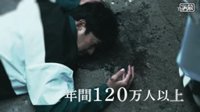

In [6]:
# Load the downloaded checkpoint
print(f"Loading checkpoint from '{CHECKPOINT_PATH}'...")
try:
    with open(CHECKPOINT_PATH, 'rb') as fh:
        check = pickle.load(fh)
        params = check['model']
        backbone = check['backbone'] # e.g., 'rdn', 'swin' etc.
        size = check['size']         # e.g., 'pro', 'base', 'small' etc.
    print(f"Checkpoint loaded successfully. Backbone: {backbone}, Size: {size}")
except FileNotFoundError:
    print(f"Error: Checkpoint file not found at '{CHECKPOINT_PATH}'.")
    raise
except Exception as e:
    print(f"Error loading checkpoint: {e}")
    raise

# Build the Thera model structure using the loaded configuration
print("Building Thera model...")
try:
    # Assuming build_thera takes features (3 for RGB), backbone name, and size name
    model = build_thera(3, backbone, size)
    print("Model built successfully.")
except NameError:
    print("Error: 'build_thera' function not defined. Did 'model.py' import correctly?")
    raise
except Exception as e:
    print(f"Error building model: {e}")
    raise


# Load the source image
print(f"Loading input image from '{INPUT_IMAGE_PATH}'...")
try:
    img_pil = Image.open(INPUT_IMAGE_PATH).convert('RGB')
    source_np = np.asarray(img_pil) / 255.0
    # Convert to JAX array and transpose to (C, H, W)
    # source_jax = jnp.asarray(source_np).transpose(2, 0, 1) # HWC -> CHW
    # print(f"Input image loaded. Shape: {source_np.shape} -> {source_jax.shape}")
    display(img_pil.resize((200, int(200 * img_pil.height / img_pil.width)))) # Display a thumbnail
except FileNotFoundError:
    print(f"Error: Input image file not found at '{INPUT_IMAGE_PATH}'.")
    raise
except Exception as e:
    print(f"Error loading image: {e}")
    raise



In [7]:
# %%
# Determine the target shape for super-resolution
source_h, source_w = source_np.shape[:2]

if TARGET_SCALE is not None:
    target_h = round(source_h * TARGET_SCALE)
    target_w = round(source_w * TARGET_SCALE)
    target_shape = (target_h, target_w)
    print(f"Using scale factor {TARGET_SCALE}. Target shape: {target_shape}")
elif TARGET_SIZE is not None:
    target_shape = TARGET_SIZE
    print(f"Using fixed target size. Target shape: {target_shape}")
else:
    # This case should be caught by earlier checks, but as a safeguard:
    raise ValueError("Target scale or size not set.")



Using scale factor 5.0. Target shape: (720, 1280)


In [8]:
# %%
print("Starting super-resolution process...")
# Ensure source_jax has the correct shape (C, H, W)
# if source_jax.ndim != 3 or source_jax.shape[0] != 3:
#      raise ValueError(f"Expected source JAX array shape (C, H, W), but got {source_jax.shape}")

# Run the main processing function
output_image_np = process(
    source_np,         # Shape (C, H_src, W_src)
    model,
    params,
    target_shape,       # Tuple (H_tgt, W_tgt)
    do_ensemble=DO_ENSEMBLE,
    patch_size_enc=PATCH_SIZE_ENC
)

# Ensure the output is on CPU and is a NumPy array for saving/displaying
output_image_np = np.asarray(output_image_np)

print("Super-resolution finished.")
print(f"Output image shape: {output_image_np.shape}") # Should be (H_tgt, W_tgt, C)

Starting super-resolution process...
Super-resolution finished.
Output image shape: (720, 1280, 3)


Saving output image to 'output_superres.jpg'...
Image saved successfully.
Loading ground truth image from 'images/720p/frame_00297.jpg' for comparison...
Displaying Super-Resolution Output vs Ground Truth:


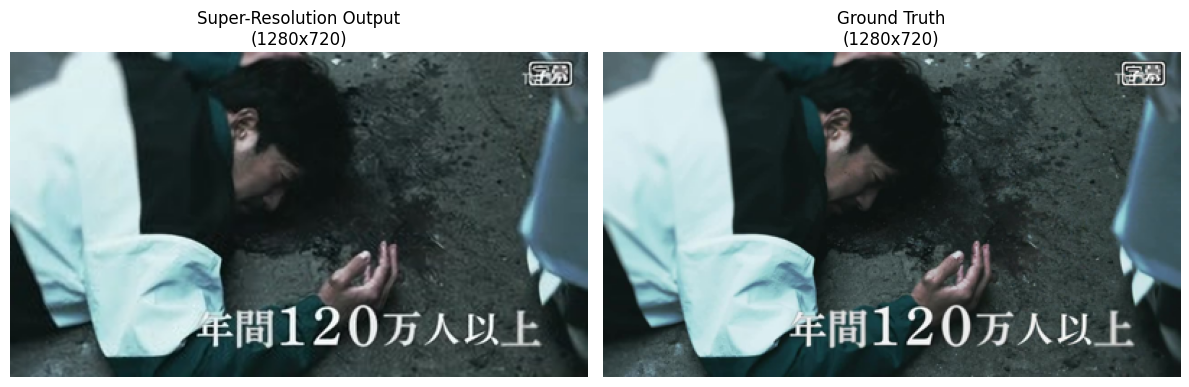

In [9]:
import matplotlib.pyplot as plt
import math

# Convert NumPy array (H, W, C) back to PIL Image for SR output
output_image_pil = Image.fromarray(output_image_np)

# Save the result
print(f"Saving output image to '{OUTPUT_IMAGE_PATH}'...")
try:
    output_image_pil.save(OUTPUT_IMAGE_PATH)
    print("Image saved successfully.")
except Exception as e:
    print(f"Error saving image: {e}")

# --- Display Comparison ---

# Define a maximum display width for thumbnails
MAX_DISPLAY_WIDTH = 400

# Prepare SR output thumbnail
sr_w, sr_h = output_image_pil.size
sr_display_w = min(sr_w, MAX_DISPLAY_WIDTH)
sr_display_h = int(sr_h * (sr_display_w / sr_w))
sr_thumb = output_image_pil.resize((sr_display_w, sr_display_h))

# Check if ground truth is available and exists
gt_thumb = None
gt_path_valid = False
if GROUND_TRUTH_IMAGE_PATH and os.path.exists(GROUND_TRUTH_IMAGE_PATH):
    print(f"Loading ground truth image from '{GROUND_TRUTH_IMAGE_PATH}' for comparison...")
    try:
        gt_image_pil = Image.open(GROUND_TRUTH_IMAGE_PATH).convert('RGB')
        gt_w, gt_h = gt_image_pil.size

        # Optionally check if GT dimensions roughly match SR output dimensions
        if abs(gt_w - sr_w) > 5 or abs(gt_h - sr_h) > 5:
            print(f"Warning: Ground truth dimensions ({gt_w}x{gt_h}) differ significantly from SR output dimensions ({sr_w}x{sr_h}).")

        # Prepare GT thumbnail
        gt_display_w = min(gt_w, MAX_DISPLAY_WIDTH)
        gt_display_h = int(gt_h * (gt_display_w / gt_w))
        gt_thumb = gt_image_pil.resize((gt_display_w, gt_display_h))
        gt_path_valid = True
    except Exception as e:
        print(f"Error loading ground truth image: {e}. Skipping comparison.")

# Display using Matplotlib
if gt_path_valid and gt_thumb:
    print("Displaying Super-Resolution Output vs Ground Truth:")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Adjust figsize as needed

    axes[0].imshow(sr_thumb)
    axes[0].set_title(f"Super-Resolution Output\n({sr_w}x{sr_h})")
    axes[0].axis('off')

    axes[1].imshow(gt_thumb)
    axes[1].set_title(f"Ground Truth\n({gt_w}x{gt_h})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    # Only display the SR output if no valid GT
    print("Displaying Super-Resolution Output (Ground Truth not provided or invalid):")
    plt.figure(figsize=(8, 8 * sr_display_h / sr_display_w)) # Adjust size
    plt.imshow(sr_thumb)
    plt.title(f"Super-Resolution Output\n({sr_w}x{sr_h})")
    plt.axis('off')
    plt.show()